# Reservation Cancellation Prediction(Kaggle) Project

## Table of contents

- [Understanding the problem](#1)
- [Data splitting](#2)
- [EDA](#3)
- [Feature engineering](#4)
- [Preprocessing and transformations](#5)
- [Baseline model](#6)
- [Linear models](#7)
- [Different classifiers](#8)
- [Feature selection](#9)
- [Hyperparameter optimization](#10)
- [Interpretation and feature importances](#11)
- [Results on the test set](#12)
- [Explaining predictions](#13)
- [Summary of the results](#14)

## Imports libraries

In [2]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

## Introduction <a name="in"></a>
<hr>

In this project, all the different supervised learning techniques will be put together to solve an interesting kaggle problem, 'Reservation Cancellation Prediction'.

### 1. Understanding the problem <a name="1"></a>

- This is a classification problem of predicting whether a customer will cancel the reservation they have made at a hotel. For this problem, I will use [Reservation Cancellation Prediction Dataset](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv). In this data set, there are about 18.000 examples and 18 features (including the target), and the goal is to estimate whether a person will cancel their booking; this column is labeled "booking_status" in the data (1 = canceled). 

- In this problem, our goal is to classify the booking status in binary. The target column 'booking_status' is a binary column, indicating whether the customer is canceled the reservation or not. (0 means not canceled/1 means canceled) 

- Also this dataset is considered a small because it only has 18 features including the target. All columns are numeric or numerically encoded categorical columns(for example, room_type_reserved seems to be a binary feature). Therefore, I might need to investigate the type of each feature and also deal with scaling problem.

In [27]:
df = pd.read_csv("data/train__dataset.csv", encoding="utf-8")

### 2. Data splitting <a name="2"></a>

In [28]:
train_df, test_df = train_test_split(df, test_size = 0.25, random_state = 123)

### 3. EDA 
1. Performed exploratory data analysis on the train set.
2. Included various summary statistics and three useful visualizations.
3. Summarized our initial observations about the data. 
4. Picked appropriate metric/metrics for assessment.

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13602 entries, 5120 to 15725
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          13602 non-null  int64  
 1   no_of_children                        13602 non-null  int64  
 2   no_of_weekend_nights                  13602 non-null  int64  
 3   no_of_week_nights                     13602 non-null  int64  
 4   type_of_meal_plan                     13602 non-null  int64  
 5   required_car_parking_space            13602 non-null  int64  
 6   room_type_reserved                    13602 non-null  int64  
 7   lead_time                             13602 non-null  int64  
 8   arrival_year                          13602 non-null  int64  
 9   arrival_month                         13602 non-null  int64  
 10  arrival_date                          13602 non-null  int64  
 11  market_segme

- It seems like there is no missing values for imputing. All columns are numeric or numerically encoded. 

In [7]:
train_df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,13602.000000,13602.000000,13602.000000,13602.000000,13602.000000,13602.000000,13602.000000,13602.000000,13602.000000,13602.000000,13602.000000,13602.000000,13602.000000,13602.000000,13602.000000,13602.000000,13602.000000,13602.000000
mean,1.850096,0.107631,0.809513,2.199971,0.318556,0.032789,0.338921,85.357006,2017.821276,7.434201,15.698941,0.802308,0.024996,0.022717,0.156080,103.498347,0.622850,0.326276
std,0.514430,0.400025,0.871218,1.420234,0.630027,0.178091,0.779091,87.044267,0.383135,3.078652,8.766855,0.644147,0.156120,0.358905,1.756763,35.326413,0.788455,0.468867
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,16.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.200000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.450000,0.000000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,127.000000,2018.000000,10.000000,23.000000,1.000000,0.000000,0.000000,0.000000,120.600000,1.000000,1.000000
max,4.000000,3.000000,7.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,13.000000,58.000000,375.500000,5.000000,1.000000


- Each column has a different scale. For example, 'no_of_week_nights' has 17 as max and 'lead_time' has 443 for max. I need to perform scaling on the data. 
- There are some outliers in some columns. For example, in no_of_previous_bookings_not_canceled has 0 as median, 0 as min, and 58 as max. Similar trend is observed in lead_time as well. 

In [8]:
train_df.shape

(13602, 18)

- The data has total of 13602 examples and 18 columns. Althogh the number of features is small, it has a reasonable number of examples. 

In [9]:
train_df.mean()

no_of_adults                               1.850096
no_of_children                             0.107631
no_of_weekend_nights                       0.809513
no_of_week_nights                          2.199971
type_of_meal_plan                          0.318556
required_car_parking_space                 0.032789
room_type_reserved                         0.338921
lead_time                                 85.357006
arrival_year                            2017.821276
arrival_month                              7.434201
arrival_date                              15.698941
market_segment_type                        0.802308
repeated_guest                             0.024996
no_of_previous_cancellations               0.022717
no_of_previous_bookings_not_canceled       0.156080
avg_price_per_room                       103.498347
no_of_special_requests                     0.622850
booking_status                             0.326276
dtype: float64

- Each numerical column has very different scale. 
- This dataset has imbalanced showing 4438 "booking canceled" samples out of 13602 in total.

In [11]:
X_train = train_df.drop(columns = ["booking_status"])
y_train = train_df["booking_status"]
X_test = test_df.drop(columns = ["booking_status"])
y_test = test_df["booking_status"]

In [12]:
y_train.sum()

4438

- Since I would like to examine whether or not a customer canceled the reservation, I focuses more on the class with a label "booking canceled". I set "booking canceled" case as positive case.

In [10]:
for c in X_train.columns:
    print(c, np.unique(X_train[c]))

no_of_adults [0 1 2 3 4]
no_of_children [0 1 2 3]
no_of_weekend_nights [0 1 2 3 4 5 6 7]
no_of_week_nights [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
type_of_meal_plan [0 1 2 3]
required_car_parking_space [0 1]
room_type_reserved [0 1 2 3 4 5 6]
lead_time [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 

Unique values stored in each features

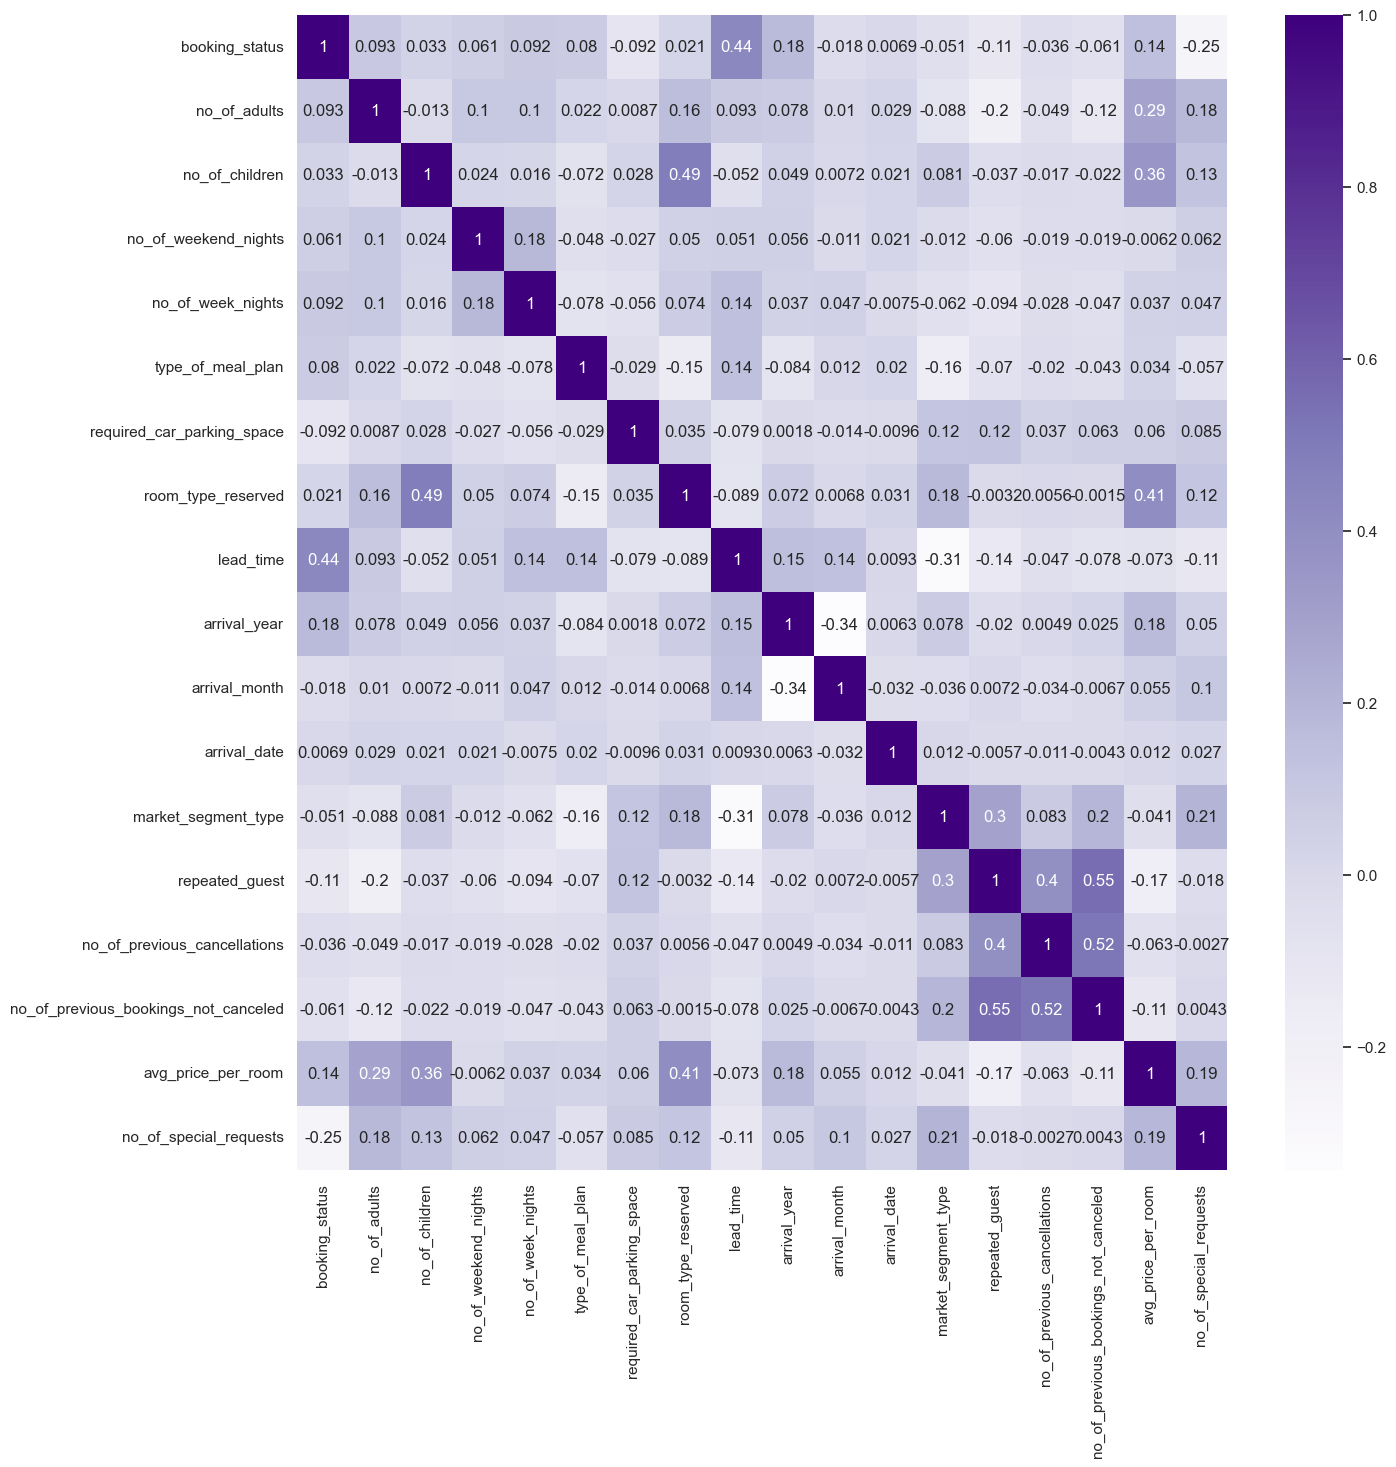

In [14]:
import seaborn as sns
cor = pd.concat((y_train, X_train), axis = 1).corr()
plt.figure(figsize = (15, 15))
sns.set(font_scale = 1)
sns.heatmap(cor, annot = True, cmap=plt.cm.Purples);

- market_segment_type, repeated_guest, no_of_previous_cancellations, and no_of_previous_bookings_not_canceled show a high correlation to each other. The feature 'lead_time' shows the highest correlation to our target column.

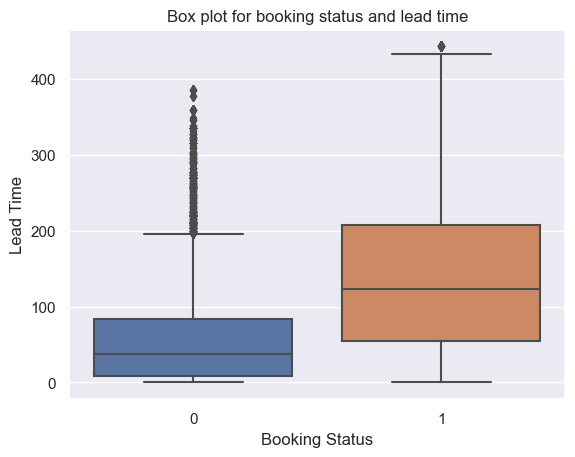

In [15]:
sns.boxplot(x='booking_status', y='lead_time', data=train_df)
plt.ylabel('Lead Time')
plt.xlabel('Booking Status')
plt.title('Box plot for booking status and lead time')
plt.show()

- According to this box plot, canceled bookings tend to have higher lead time than not canceled bookings. However, there are much more outlier lead times in uncanceled reservation case, which makes us to investigate the data more carefully.

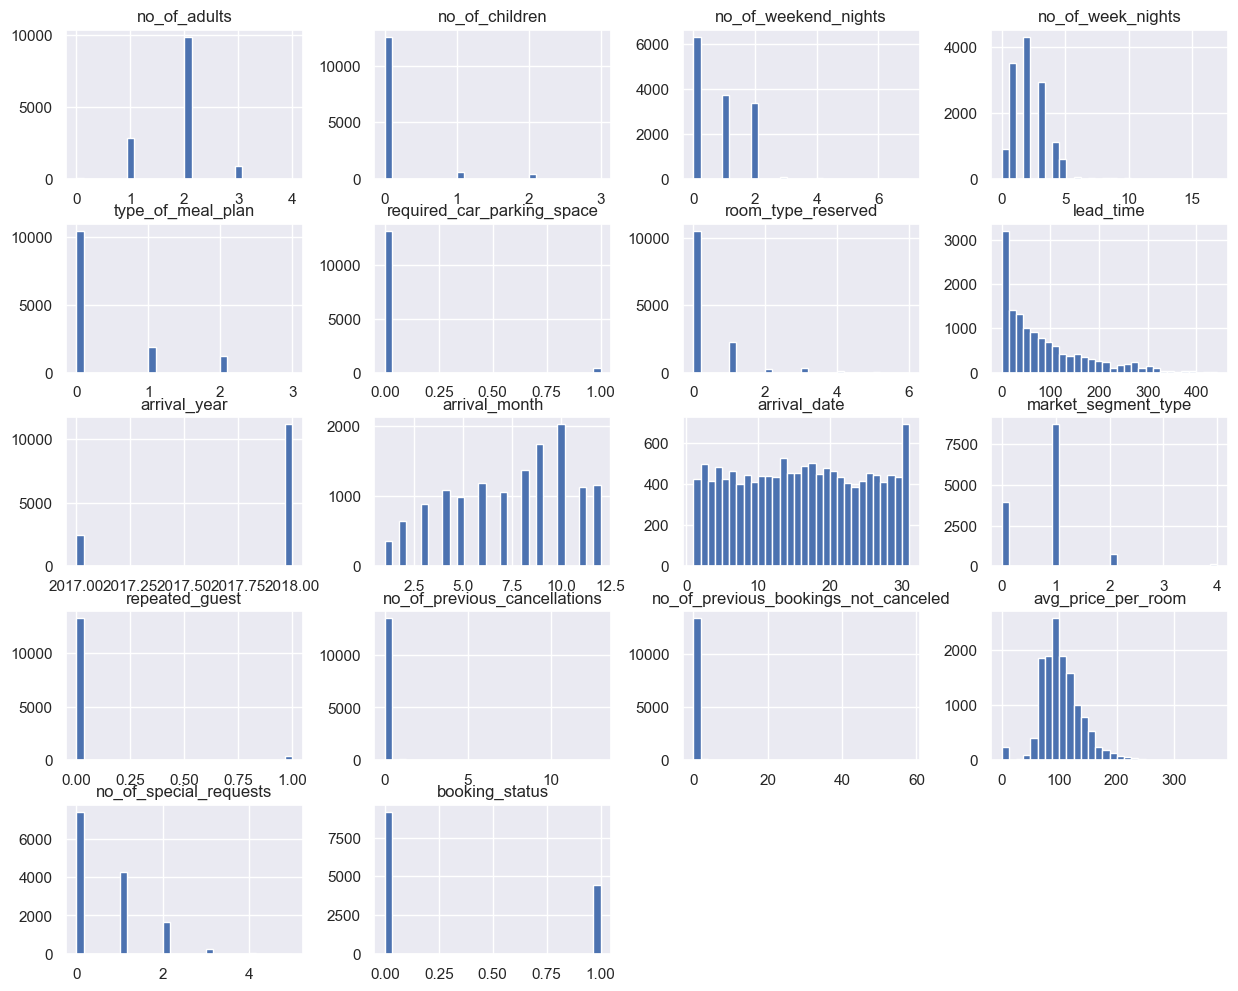

In [16]:
train_df.hist(figsize=(15,12), bins =30);

- According to this plot, repreated_guest, required_car_parking_space, and booking status are binary features. Also, type_of_meal_plan, room_type_reserved, and market_segment_type are categorical features.

In [17]:
scoring = {'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score, average ="macro")}

- Metric: I would include recall since I think spotting the as many positive cases as possible among all the positive cases. Also, I would add f1 score with macro average to measure the general performance of our model since both classes look important similarly, and want to deal with this class imbalance by mitigating the influence of the bigger class.

#### Initial observation
* The dataset has no missing values and all columns are either numeric or numerically encoded. However, the columns have different scales, so scaling is necessary. 
* There are 13602 examples and 18 columns, which is a reasonable number of examples. However, the dataset is imbalanced with 4438 out of 13602 samples being "booking canceled." 
* There is high correlation between some of the columns, such as market segment type, repeated guest, no of previous cancellations, no of previous bookings not canceled, and lead time. 
* There are more relevant columns and irrelevant columns to predict our target. For example, lead_time seems relevant, and arrival_date seems irrelevant.
* There are some outliers and noises implying that we need to preprocess and clear our data before training. 


## 4. Feature engineering <a name="4"></a>
1. Carried out feature engineering. Extracted new features relevant for the problem and work with our new feature set; feature engineering and preprocessing. 

In [19]:
X_train = X_train.assign(net_bookings = X_train["no_of_previous_bookings_not_canceled"] - X_train["no_of_previous_cancellations"])
X_test = X_test.assign(net_bookings = X_test["no_of_previous_bookings_not_canceled"] - X_test["no_of_previous_cancellations"])
X_train.iloc[:10]

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,net_bookings
5120,2,0,2,1,0,0,0,22,2018,7,9,0,0,0,0,85.00,0,0
17421,2,2,0,3,0,0,3,199,2018,7,26,1,0,0,0,168.30,1,0
5177,1,0,0,1,0,1,1,0,2018,7,23,1,0,0,0,68.85,2,0
1493,1,0,0,2,0,0,0,5,2018,5,24,2,0,0,0,100.00,0,0
18026,2,0,2,0,1,0,0,39,2018,6,26,1,0,0,0,89.10,0,0
8103,2,0,2,2,1,0,0,95,2018,10,8,1,0,0,0,108.00,2,0
10811,3,0,0,3,0,0,1,116,2018,12,22,1,0,0,0,135.00,2,0
685,2,0,1,2,0,0,0,141,2018,6,3,0,0,0,0,132.00,0,0
16164,2,0,1,4,0,0,0,115,2018,5,4,1,0,0,0,99.45,1,0
7155,2,0,1,1,0,0,0,2,2017,8,10,1,0,0,0,98.00,1,0


- It seems like there is strong correlation between this two columns and both are checking the customers behavior whether or not they canceled the bookings they made. It maybe reasonable to make a combined column to capture the both columns.

## 5. Preprocessing and transformations <a name="5"></a>
1. Identified different feature types and the transformations we would apply on each feature type. 
2. Defined a column transformer. 

In [20]:
categorical = ["type_of_meal_plan", "room_type_reserved", "arrival_month", "market_segment_type"]
numerical = ["no_of_adults", "no_of_children", "no_of_weekend_nights", "no_of_week_nights", "lead_time", 
            "arrival_year", "no_of_previous_cancellations", "no_of_previous_bookings_not_canceled", "avg_price_per_room", "no_of_special_requests", "net_bookings"]
binary = ["required_car_parking_space","repeated_guest"]
drop = ["arrival_date"]

In [21]:
ct = make_column_transformer(
    (StandardScaler(), numerical),
    (OneHotEncoder(), categorical),
    (OneHotEncoder(drop = "if_binary"), binary),
    ("drop", drop)
)
ct

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['no_of_adults', 'no_of_children',
                                  'no_of_weekend_nights', 'no_of_week_nights',
                                  'lead_time', 'arrival_year',
                                  'no_of_previous_cancellations',
                                  'no_of_previous_bookings_not_canceled',
                                  'avg_price_per_room',
                                  'no_of_special_requests', 'net_bookings']),
                                ('onehotencoder-1', OneHotEncoder(),
                                 ['type_of_meal_plan', 'room_type_reserved',
                                  'arrival_month', 'market_segment_type']),
                                ('onehotencoder-2',
                                 OneHotEncoder(drop='if_binary'),
                                 ['required_car_parking_space',
                                  'repeated_guest']),
                                ('drop', 'drop', ['arrival_date'])])

## 6. Baseline model <a name="6"></a>
Tried `scikit-learn`'s baseline model and reported results.

In [22]:
dummy = DummyClassifier(strategy = "prior")
# pipe_dummy = make_pipeline(ct, DummyClassifier(strategy = "prior"))

rst_dummy = cross_validate(dummy, X_train, y_train, return_train_score = True, scoring = scoring)
pd.DataFrame(rst_dummy)

,fit_time,score_time,test_recall,train_recall,test_f1_score,train_f1_score
0,0.005229,0.002107,0.0,0.0,0.402503,0.402537
1,0.001105,0.001569,0.0,0.0,0.402503,0.402537
2,0.001303,0.001477,0.0,0.0,0.402592,0.402515
3,0.000991,0.001528,0.0,0.0,0.402592,0.402515
4,0.000877,0.001319,0.0,0.0,0.402460,0.402547


In [23]:
print("test_f1_score", rst_dummy["test_f1_score"])
print("mean_test_f1_score", np.mean(rst_dummy["test_f1_score"]))

test_f1_score [0.40250329 0.40250329 0.4025917  0.4025917  0.40246046]
mean_test_f1_score 0.4025300880241304


The cv scores for baseline for each fold are [0.40250329 0.40250329 0.4025917  0.4025917  0.40246046], averaging 0.4025300880241304.

## 7. Linear models <a name="7"></a>
1. Tried logistic regression as a first real attempt. 
2. Carried out hyperparameter tuning to explore different values for the complexity hyperparameter `C`. 
3. Reported validation scores along with standard deviation. 
4. Summarized the results.

In [26]:
from scipy.stats import loguniform, uniform
pipe_lr = make_pipeline(ct, LogisticRegression(max_iter=3000))
param_grid = {
    "logisticregression__C": loguniform(1e-4, 1e6),
}
random_search = RandomizedSearchCV(
    pipe_lr, param_grid, n_iter=3000, verbose=1, n_jobs=-1, random_state=123, return_train_score=True, scoring = scoring, refit='f1_score'
)
result = random_search.fit(X_train, y_train).cv_results_

pd.DataFrame(result)[
    ["params", 
    "std_train_f1_score", 
    "std_test_f1_score",
    "mean_train_recall", 
    "mean_test_recall",
    "mean_train_f1_score", 
    "mean_test_f1_score", 
    ]
].sort_values('mean_test_f1_score', ascending=False).T

Fitting 5 folds for each of 3000 candidates, totalling 15000 fits


,502,317,2671,1155,412,1161,406,1876,1864,1861,...,118,2414,2309,671,1167,2732,1051,1765,494,2583
params,{'logisticregression__C': 32770.30729403243},{'logisticregression__C': 303755.1963651784},{'logisticregression__C': 2492.5644047219703},{'logisticregression__C': 248549.98339919126},{'logisticregression__C': 295934.3643823119},{'logisticregression__C': 33792.69461424464},{'logisticregression__C': 1178.0144092093783},{'logisticregression__C': 12385.210884410331},{'logisticregression__C': 50.38545754652127},{'logisticregression__C': 51.460509899242986},...,{'logisticregression__C': 0.00010638506070763589},{'logisticregression__C': 0.00010629198061895803},{'logisticregression__C': 0.00010565793620433131},{'logisticregression__C': 0.00010493467259742053},{'logisticregression__C': 0.00010318495783861273},{'logisticregression__C': 0.00010312910365921005},{'logisticregression__C': 0.00010027692663352717},{'logisticregression__C': 0.00010031350877570558},{'logisticregression__C': 0.00010018873107185313},{'logisticregression__C': 0.00010015632554777092}
std_train_f1_score,0.001054,0.000991,0.001022,0.001022,0.001026,0.00104,0.001054,0.001019,0.000991,0.000979,...,0.000554,0.000745,0.000585,0.000303,0.001277,0.001277,0.000539,0.000539,0.000744,0.000744
std_test_f1_score,0.005267,0.005267,0.005368,0.005368,0.005368,0.005368,0.005368,0.005368,0.005368,0.005368,...,0.003179,0.003224,0.003185,0.002821,0.003779,0.003779,0.002809,0.002809,0.002721,0.002721
mean_train_recall,0.644942,0.644885,0.644829,0.644829,0.644942,0.644885,0.644942,0.644885,0.644885,0.644829,...,0.01059,0.010478,0.010083,0.009745,0.007042,0.007042,0.00507,0.00507,0.00445,0.00445
mean_test_recall,0.642412,0.642412,0.642412,0.642412,0.642412,0.642412,0.642412,0.642412,0.642412,0.642412,...,0.010365,0.010139,0.009688,0.009463,0.00721,0.00721,0.005183,0.005183,0.004506,0.004506
mean_train_f1_score,0.775046,0.775039,0.774996,0.774996,0.775064,0.775039,0.775046,0.775021,0.775039,0.775031,...,0.413813,0.413694,0.413277,0.412919,0.410047,0.410047,0.407945,0.407945,0.407283,0.407283
mean_test_f1_score,0.773517,0.773517,0.773446,0.773446,0.773446,0.773446,0.773446,0.773446,0.773446,0.773446,...,0.413565,0.413326,0.412849,0.412612,0.410214,0.410214,0.408059,0.408059,0.407336,0.407336


- I conducted 5 folds RandomizedSearchCV (5000 trainings in total) with n_iter=1000 in the range of C [1e-4, 1e6] got the the best mean test score, 0.807749. I got the three best hyperparameter C, 303755.1963651784, 32770.30729403243, and 0.10995320430205857. However, since higher C in logistic regression increases model complexity and makes very specific model, choosing C = 0.10995320430205857 seems to be a better idea. C = 0.10995320430205857 also shows pretty decent standard deviation of test result across each fold, as sd = 0.004902.

## 8. Different classifiers <a name="8"></a>
1. Tried 3 other models (aside from logistic regression), including tree-based ensemble models.
2. Summarized the results.

In [21]:
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
pipe_lgbm = make_pipeline(ct, LGBMClassifier(random_state=123))
pipe_xgb= make_pipeline(ct, XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0))
pipe_rf = make_pipeline(ct, RandomForestClassifier(random_state = 123))
classifiers = {
    "logistic regression": pipe_lr,
    "lgbm": pipe_lgbm,
    "xgb": pipe_xgb,
    "random forest": pipe_rf
}
result = {}
for (name, model) in classifiers.items():
    rst_temp = cross_validate(model, X_train, y_train, return_train_score = True, scoring = scoring)
    for k in rst_temp.keys():
        rst_temp[k] = np.mean(rst_temp[k])
    result[name] = rst_temp
pd.DataFrame(result).T

,fit_time,score_time,test_recall,train_recall,test_f1_score,train_f1_score
logistic regression,0.101549,0.004580,0.640608,0.642632,0.772708,0.774360
lgbm,0.315910,0.008535,0.780081,0.820865,0.864088,0.890634
xgb,0.444404,0.006316,0.786840,0.873254,0.864833,0.925370
random forest,0.551390,0.037851,0.778506,0.992958,0.864742,0.996108


- Any of the three models(lgbm, xgb, random forest) show the higher performance in terms of test_f1_score by 0.09 approximately. (Although the train_f1_score for random forest almost 1, meaning overfitting, the test score doesn't decrease in this case.) Also, test_recall are better in the 3 ensemble models than in logistic regression model over 0.1. However, compared to logistic regression, these ensemble models require 3 times or more time cost.

## 9. Feature selection <a name="9"></a>
1. Selected relevant features. 
2. Summarized the results. 

In [22]:
from sklearn.feature_selection import RFECV

pipe_lr_rfe = make_pipeline(ct, RFECV(LogisticRegression(max_iter=1000), cv=10), LogisticRegression(max_iter=1000))
pipe_lgbm_rfe = make_pipeline(ct, RFECV(LogisticRegression(max_iter=1000), cv=10), LGBMClassifier(random_state=123))
pipe_xgb_rfe = make_pipeline(ct, RFECV(LogisticRegression(max_iter=1000), cv=10), XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0))
pipe_rf_rfe = make_pipeline(ct, RFECV(LogisticRegression(max_iter=1000), cv=10), RandomForestClassifier(random_state = 123))

classifiers = {
    "logistic regression": pipe_lr,
    "logistic regression rfe": pipe_lr_rfe,
    "lgbm": pipe_lgbm,
    "lgbm rfe": pipe_lgbm_rfe,
    "xgb": pipe_xgb,
    "xgb rfe": pipe_xgb_rfe,
    "random forest": pipe_rf,
    "random forest rfe": pipe_rf_rfe
}

for (name, model) in classifiers.items():
    rst_temp = cross_validate(model, X_train, y_train, return_train_score = True, scoring = scoring)
    for k in rst_temp.keys():
        rst_temp[k] = np.mean(rst_temp[k])
    result[name] = rst_temp
pd.DataFrame(result).T

,fit_time,score_time,test_recall,train_recall,test_f1_score,train_f1_score
logistic regression,0.103357,0.004873,0.640608,0.642632,0.772708,0.774360
lgbm,0.316352,0.008609,0.780081,0.820865,0.864088,0.890634
xgb,0.439769,0.006271,0.786840,0.873254,0.864833,0.925370
random forest,0.547170,0.037633,0.778506,0.992958,0.864742,0.996108
logistic regression rfe,18.782492,0.004790,0.639258,0.643421,0.772672,0.775162
lgbm rfe,18.995081,0.008831,0.779628,0.815739,0.862207,0.887107
xgb rfe,18.960453,0.006460,0.777376,0.858889,0.859438,0.917021
random forest rfe,19.093774,0.037489,0.774452,0.990705,0.859272,0.994810


- Feature selection version of each model does not improve the performance of the model. Rather, it seems to be slightly worse in overall. Furthermore, fit_time for rfe versions is extremely higher than the original version. Therefore, it might be better to discard the rfe steps.

## 10. Hyperparameter optimization <a name="10"></a>
1. Optimized hyperparameters for the models, utilizing `sklearn`'s methods for hyperparameter optimization [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
2. Summarized the results 
3. Picked the best performing models from the previous steps and tuned hyperparameters for that model 


In [23]:
param_grid = {
    "lgbmclassifier__num_leaves": [int(x) for x in loguniform(2, 100).rvs(100)],
    "lgbmclassifier__max_depth": [int(x) for x in loguniform(1, 100).rvs(100)],
    "lgbmclassifier__learning_rate": loguniform(1e-2, 10),
    "lgbmclassifier__n_estimators": [int(x) for x in loguniform(100, 1000).rvs(100)]
}

random_search = RandomizedSearchCV(
    pipe_lgbm, param_grid, n_iter=100, verbose=1, n_jobs=-1, random_state=123, return_train_score=True, scoring = scoring, refit='f1_score'
)
lgbm_result = random_search.fit(X_train, y_train)
lgbm_rst = lgbm_result.cv_results_

lgbm_rst_df = pd.DataFrame(lgbm_rst)[
    ["params", 
    "std_train_f1_score", 
    "std_test_f1_score",
    "mean_train_recall", 
    "mean_test_recall",
    "mean_train_f1_score", 
    "mean_test_f1_score", 
    ]
].sort_values('mean_test_f1_score', ascending=False).T
lgbm_rst_df

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,33,14,53,41,67,91,3,88,86,57,...,61,35,76,73,38,72,17,97,90,92
params,{'lgbmclassifier__learning_rate': 0.0527919486...,{'lgbmclassifier__learning_rate': 0.0895068854...,{'lgbmclassifier__learning_rate': 0.0215862158...,{'lgbmclassifier__learning_rate': 0.1116154089...,{'lgbmclassifier__learning_rate': 0.0231879879...,{'lgbmclassifier__learning_rate': 0.0797683128...,{'lgbmclassifier__learning_rate': 0.1070370296...,{'lgbmclassifier__learning_rate': 0.1383395788...,{'lgbmclassifier__learning_rate': 0.0374128563...,{'lgbmclassifier__learning_rate': 0.2706334358...,...,{'lgbmclassifier__learning_rate': 4.0486206791...,{'lgbmclassifier__learning_rate': 4.5124773343...,{'lgbmclassifier__learning_rate': 5.6298522688...,{'lgbmclassifier__learning_rate': 2.6291252893...,{'lgbmclassifier__learning_rate': 3.0714107749...,{'lgbmclassifier__learning_rate': 2.3150561064...,{'lgbmclassifier__learning_rate': 3.0131614432...,{'lgbmclassifier__learning_rate': 2.9390649641...,{'lgbmclassifier__learning_rate': 8.9491686144...,{'lgbmclassifier__learning_rate': 8.8571440293...
std_train_f1_score,0.001422,0.001356,0.001558,0.001347,0.001108,0.000948,0.000891,0.001412,0.001444,0.001239,...,0.076702,0.000013,0.18582,0.06878,0.0044,0.000975,0.000837,0.000837,0.000971,0.001261
std_test_f1_score,0.004911,0.004311,0.004738,0.003127,0.005978,0.003497,0.003387,0.004772,0.004311,0.004914,...,0.078872,0.000053,0.182231,0.068429,0.010293,0.005551,0.005367,0.005367,0.005584,0.006466
mean_train_recall,0.87731,0.870268,0.833371,0.922826,0.840638,0.897984,0.97758,0.957357,0.815119,0.902772,...,0.173078,0.0,0.534698,0.440588,0.535769,0.545628,0.551937,0.551937,0.555092,0.260928
mean_test_recall,0.787514,0.788867,0.784811,0.792472,0.783684,0.785712,0.789093,0.790893,0.777602,0.787967,...,0.171815,0.0,0.533577,0.442914,0.535827,0.545511,0.550919,0.550919,0.555425,0.261375
mean_train_f1_score,0.926296,0.921501,0.89932,0.952667,0.904732,0.939513,0.98541,0.973852,0.887187,0.941224,...,0.462622,0.40253,0.321752,0.264964,0.238687,0.232976,0.230718,0.230718,0.228517,0.200328
mean_test_f1_score,0.867952,0.866214,0.865903,0.865714,0.865441,0.86528,0.864768,0.864525,0.862971,0.862921,...,0.463303,0.40253,0.319935,0.266085,0.238042,0.233156,0.230858,0.230858,0.228634,0.200754


In [24]:
lgbm_result.best_params_

{'lgbmclassifier__learning_rate': 0.05279194868024991,
 'lgbmclassifier__max_depth': 52,
 'lgbmclassifier__n_estimators': 604,
 'lgbmclassifier__num_leaves': 21}

- The best performance hyperparameters for lightGBM is learning_rate: 0.029587323843539553, max_depth: 9, n_estimators: 474, and num_leaves: 67

**XGB tunning**

In [25]:
param_grid = {
    "xgbclassifier__max_depth": [int(x) for x in loguniform(1, 100).rvs(100)],
    "xgbclassifier__learning_rate": loguniform(1e-2, 10),
    "xgbclassifier__n_estimators": [int(x) for x in loguniform(100, 1000).rvs(100)],
    "xgbclassifier__gamma": loguniform(1e-6, 1e-1),
    "xgbclassifier__subsample": uniform(0.1, 0.9),
    "xgbclassifier__colsample_bytree": uniform(0.1, 0.9),
}

random_search = RandomizedSearchCV(
    pipe_xgb, param_grid, n_iter=100, verbose=1, n_jobs=-1, random_state=123, return_train_score=True, scoring=scoring, refit='f1_score'
)
xgb_result = random_search.fit(X_train, y_train)
xgb_rst = xgb_result.cv_results_

xgb_rst_df = pd.DataFrame(xgb_rst)[    ["params",     
                                        "std_train_f1_score",     
                                        "std_test_f1_score",    
                                        "mean_train_recall",     
                                        "mean_test_recall",   
                                        "mean_train_f1_score",      
                                        "mean_test_f1_score",     ]
].sort_values('mean_test_f1_score', ascending=False).T
xgb_rst_df


Fitting 5 folds for each of 100 candidates, totalling 500 fits


,91,94,5,0,28,16,76,78,19,51,...,87,98,54,96,61,65,56,36,35,46
params,{'xgbclassifier__colsample_bytree': 0.75934109...,{'xgbclassifier__colsample_bytree': 0.61242369...,{'xgbclassifier__colsample_bytree': 0.68924917...,{'xgbclassifier__colsample_bytree': 0.72682226...,{'xgbclassifier__colsample_bytree': 0.73782765...,{'xgbclassifier__colsample_bytree': 0.93261924...,{'xgbclassifier__colsample_bytree': 0.38783064...,{'xgbclassifier__colsample_bytree': 0.77705614...,{'xgbclassifier__colsample_bytree': 0.69996209...,{'xgbclassifier__colsample_bytree': 0.67099804...,...,{'xgbclassifier__colsample_bytree': 0.52246653...,{'xgbclassifier__colsample_bytree': 0.65546747...,{'xgbclassifier__colsample_bytree': 0.14130570...,{'xgbclassifier__colsample_bytree': 0.56586111...,{'xgbclassifier__colsample_bytree': 0.10317898...,{'xgbclassifier__colsample_bytree': 0.68326404...,{'xgbclassifier__colsample_bytree': 0.23389989...,{'xgbclassifier__colsample_bytree': 0.33758264...,{'xgbclassifier__colsample_bytree': 0.10668374...,{'xgbclassifier__colsample_bytree': 0.18733434...
std_train_f1_score,0.000195,0.002247,0.000385,0.000355,0.00125,0.000213,0.00122,0.000175,0.002159,0.00065,...,0.000013,0.108572,0.058409,0.076682,0.07668,0.112172,0.078199,0.047005,0.014432,0.017583
std_test_f1_score,0.00481,0.003415,0.004474,0.005359,0.004909,0.006945,0.00424,0.005042,0.006041,0.004094,...,0.000053,0.111606,0.055488,0.076667,0.076678,0.111197,0.074932,0.047816,0.01404,0.01327
mean_train_recall,0.991494,0.908348,0.989353,0.988339,0.860241,0.992902,0.930092,0.99386,0.827231,0.970257,...,0.0,0.491248,0.399549,0.4,0.4,0.637578,0.472452,0.892172,0.999944,0.999549
mean_test_recall,0.785716,0.76521,0.778281,0.780756,0.762279,0.782336,0.767689,0.780306,0.754169,0.780529,...,0.0,0.49242,0.399324,0.4,0.4,0.637836,0.481523,0.893234,0.999775,0.999775
mean_train_f1_score,0.995438,0.958667,0.994389,0.99399,0.929621,0.995733,0.966069,0.996027,0.911498,0.983484,...,0.40253,0.372912,0.354846,0.339915,0.339921,0.3399,0.323724,0.28211,0.253228,0.254794
mean_test_f1_score,0.866971,0.865377,0.864416,0.863766,0.862298,0.861805,0.860733,0.859363,0.859286,0.858762,...,0.40253,0.376042,0.357437,0.339949,0.339926,0.338675,0.327517,0.282697,0.253018,0.252668


In [26]:
xgb_result.best_params_

{'xgbclassifier__colsample_bytree': 0.7593410955636355,
 'xgbclassifier__gamma': 0.0024574040777458404,
 'xgbclassifier__learning_rate': 0.014312082842934941,
 'xgbclassifier__max_depth': 39,
 'xgbclassifier__n_estimators': 784,
 'xgbclassifier__subsample': 0.9612181228279543}

- The best performance hyperparameters for XGB is learning_rate: 0.029587323843539553, max_depth: 9, n_estimators: 474, gamma: , subsample: , and colsample_bytree: 67

## 11. Interpretation and feature importances <a name="1"></a>
1. Explained feature importances of the best performing model, utilizing 'shap' 
2. Summarized our observations 

In [27]:
import shap
pipe_lgbm_best = make_pipeline(ct, LGBMClassifier(learning_rate = lgbm_result.best_params_['lgbmclassifier__learning_rate'], 
                                                  max_depth = lgbm_result.best_params_['lgbmclassifier__max_depth'], 
                                                  n_estimators = lgbm_result.best_params_['lgbmclassifier__n_estimators'], 
                                                  num_leaves = lgbm_result.best_params_['lgbmclassifier__num_leaves'], random_state=123))
pipe_xgb_best = make_pipeline(ct, XGBClassifier(learning_rate = xgb_result.best_params_['xgbclassifier__learning_rate'], 
                                                  max_depth = xgb_result.best_params_['xgbclassifier__max_depth'], 
                                                  n_estimators = xgb_result.best_params_['xgbclassifier__n_estimators'], 
                                                  gamma = xgb_result.best_params_['xgbclassifier__gamma'], 
                                                  subsample = xgb_result.best_params_['xgbclassifier__subsample'], 
                                                  colsample_bytree = xgb_result.best_params_['xgbclassifier__colsample_bytree'], 
                                                  random_state=123, eval_metric="logloss", verbosity=0))
pipe_lgbm_best.fit(X_train, y_train)
ohe_feature_names = (
    pipe_lgbm_best.named_steps["columntransformer"]
    .named_transformers_["onehotencoder-1"]
    .get_feature_names_out(categorical)
    .tolist()
)
binary_names = (
    pipe_lgbm_best.named_steps["columntransformer"]
    .named_transformers_["onehotencoder-2"]
    .get_feature_names_out()
    .tolist()
)
feature_names = (
    numerical + ohe_feature_names + binary_names
)

X_train_enc = pd.DataFrame(
    data=ct.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

lgbm_explainer = shap.TreeExplainer(pipe_lgbm_best.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

# train_lgbm_shap_values = lgbm_explainer(X_train_enc)

shap_abs_values = np.abs(train_lgbm_shap_values[1]).mean(0)
pd.DataFrame(data=shap_abs_values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


,SHAP
lead_time,1.976279
no_of_special_requests,1.181602
avg_price_per_room,0.793677
market_segment_type_1,0.552494
market_segment_type_0,0.502954
arrival_month_12,0.419066
required_car_parking_space_1,0.234011
no_of_weekend_nights,0.176973
no_of_week_nights,0.156374
arrival_year,0.134587


Feature 'lead_time' has the highest importance(magnitude).

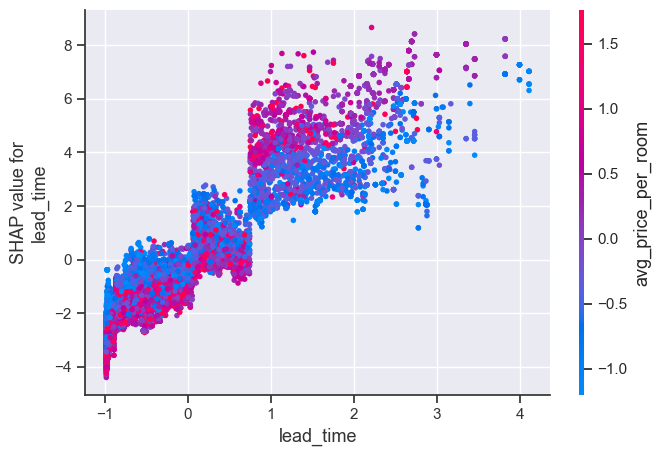

In [28]:
shap.initjs()
shap.dependence_plot("lead_time", train_lgbm_shap_values[1], X_train_enc)

- This shap plot tells us higher lead_time has more importance to predict class 1(booking_status = 1). As lead_time increases, the importance of the feature 'lead_time' also increases in predicting the target to be 1. However, it seems to be more outliers for the higher lead_time than lower_lead time.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


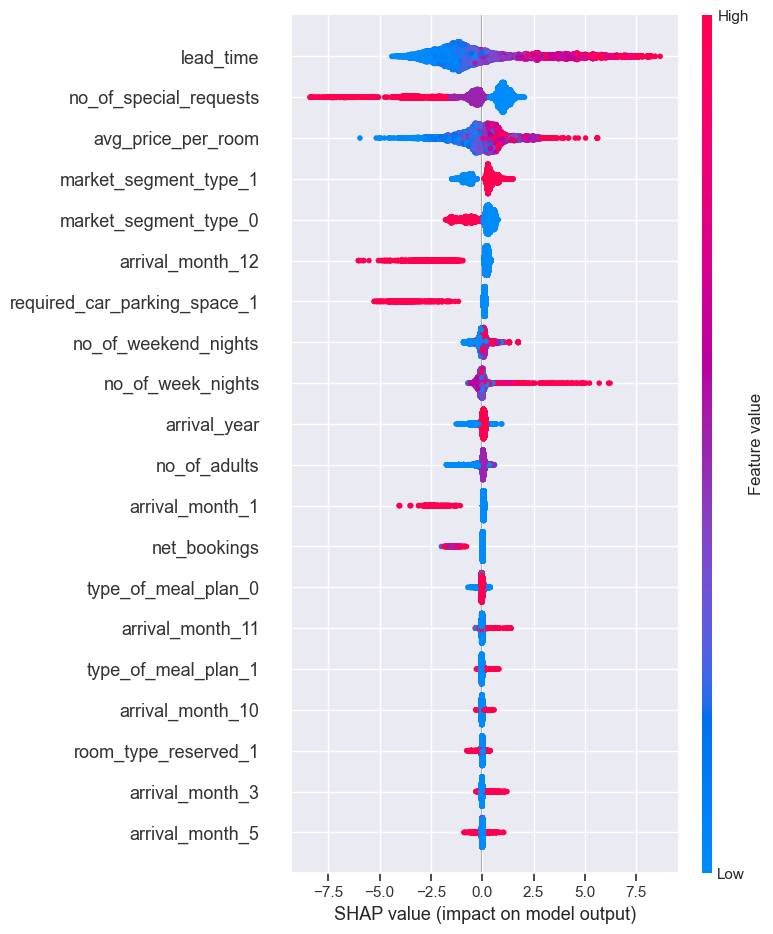

In [29]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc)

For a specific example,

Observation
* We can observe that features such as lead_time, no_of_special_request, avg_price_per_room, market_segment_type, arrival_month, required_car_parking_space are important to predict our target.
* With Shap plot, we can check which direction each feature contribute to our prediction. For example, a longer lead_time has a great positive impact on class 1, while smaller lead_time can cause negative contribution to class 1. Also we can check that higher lead_time has much more importance on our prediction with Shap dependency_plot and summary_plot.
* Features such as arrival month or type of meal plan does have much impact on our prediction.

## 12. Results on the test set <a name="12"></a>
1. Tried out best performing model on the test data and report test scores. 

In [30]:
# pipe_lgbm_best is fitted already in Q11.
y_hat = pipe_lgbm_best.predict(X_test)
f1 = f1_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
print(f'f1_score: {f1:.3f}', f'recall_score: {recall:.3f}')

f1_score: 0.825 recall_score: 0.799


In [31]:
# result from Q10 (cv scores for the best parameter)
lgbm_rst_df.iloc[:, 0]

params                 {'lgbmclassifier__learning_rate': 0.0527919486...
std_train_f1_score                                              0.001422
std_test_f1_score                                               0.004911
mean_train_recall                                                0.87731
mean_test_recall                                                0.787514
mean_train_f1_score                                             0.926296
mean_test_f1_score                                              0.867952
Name: 33, dtype: object

* Validation f1_score: 0.867952
* Test f1_score: 0.825
* Validation recall_score: 0.787514
* Test recall_score: 0.799


- While the test scores do not match exactly with the validation scores, they are quite similar. Recall is slightly high, while test f1 score drops by about 4 percentage points. I would trust this result since multiple of assessments, along with the number of cross-validation was conducted to generalize the result to unseen data and boost trust in the model's performance.
- Since we used the same data set to assess the model's performance during our hyperparameter tuning, optimization bias can be a problem. In this case, our validation scores accord with the test scores. Therefore, we can conclude there is no critical hyperparameter overfitting observed.

## 13. Explaining predictions 
1. Took one test prediction and explained it with SHAP force plots.  

In [32]:
X_test_enc = pd.DataFrame(
    data=ct.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [33]:
pipe_lgbm_best.named_steps["lgbmclassifier"].predict_proba(X_test_enc)[1]

array([0.84892248, 0.15107752])

In [34]:
pipe_lgbm_best.named_steps["lgbmclassifier"].predict(X_test_enc, raw_score=True)[1] 

-1.7261748255784795

In [35]:
lgbm_explainer.expected_value[1]

-1.7204900341145055

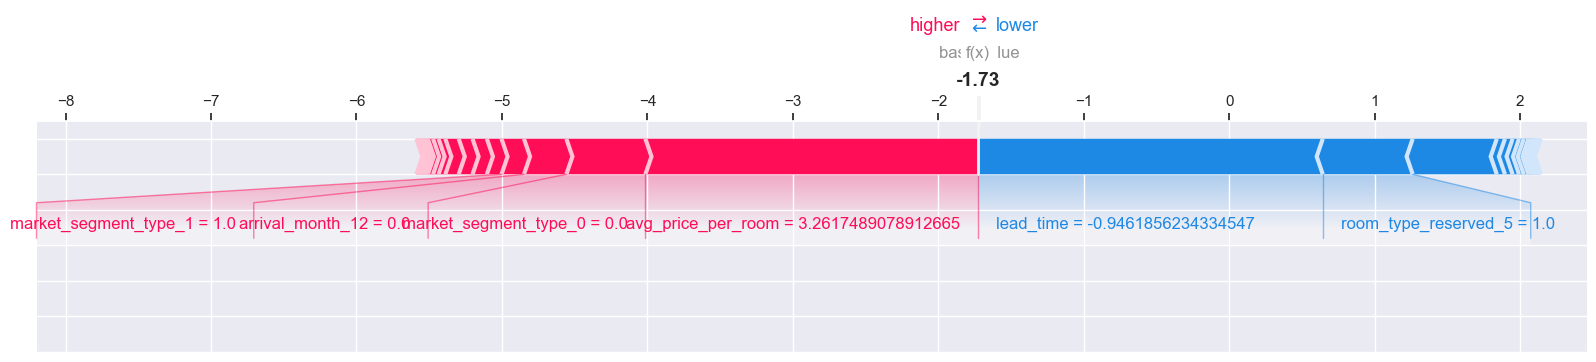

In [36]:
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][1, :],
    X_test_enc.iloc[1, :],
    matplotlib=True,
)

- With a base value of -1.6798175644550326 for class 1, the biggest contributor to this specific test example is lead_time. Lead_time has a negative influence on the target, while avg_price_per_room has a positive contribution. Additionally, the market_segment_type and arrival_month features push this example towards a positive classification with respect to class 1

## 14. Summary of results <a name="13"></a>
1. Reported our final test score along with the metric we used. 
2. Writed concluding remarks.
3. Discussed other ideas that we did not try but could potentially improve the performance/interpretability . 

In [37]:
final_classifiers = {
    "dummy": dummy,
    "logistic regression": pipe_lr,
    "lgbm": pipe_lgbm,
    "xgb": pipe_xgb,
    "random forest": pipe_rf,
    "logistic regression rfe": pipe_lr_rfe,
    "lgbm rfe": pipe_lgbm_rfe,
    "xgb rfe": pipe_xgb_rfe,
    "random forest rfe": pipe_rf_rfe,
    "lgbm_best": pipe_lgbm_best,
    "xgb_best": pipe_xgb_best
}
final_result = {}
for (name, model) in final_classifiers.items():
    rst_temp = cross_validate(model, X_train, y_train, return_train_score = True, scoring = scoring)
    for k in rst_temp.keys():
        rst_temp[k] = np.mean(rst_temp[k])
    final_result[name] = rst_temp
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    final_result[name]["f1_testset"] = f1_score(y_test, y_hat)
    final_result[name]["recall_testset"] = recall_score(y_test, y_hat)

pd.DataFrame(final_result).T

,fit_time,score_time,test_recall,train_recall,test_f1_score,train_f1_score,f1_testset,recall_testset
dummy,0.000865,0.001428,0.000000,0.000000,0.402530,0.402530,0.000000,0.000000
logistic regression,0.100404,0.004533,0.640608,0.642632,0.772708,0.774360,0.693202,0.654255
lgbm,0.314966,0.008301,0.780081,0.820865,0.864088,0.890634,0.814942,0.790559
xgb,0.451007,0.006230,0.786840,0.873254,0.864833,0.925370,0.822069,0.792553
random forest,0.551218,0.037874,0.778506,0.992958,0.864742,0.996108,0.817301,0.785239
logistic regression rfe,18.596471,0.004597,0.639258,0.643421,0.772672,0.775162,0.695376,0.654920
lgbm rfe,18.799603,0.008318,0.779628,0.815739,0.862207,0.887107,0.812714,0.790559
xgb rfe,18.839326,0.006206,0.777376,0.858889,0.859438,0.917021,0.813803,0.791888
random forest rfe,18.929912,0.037040,0.774452,0.990705,0.859272,0.994810,0.807428,0.780585
lgbm_best,1.299697,0.020085,0.787514,0.877310,0.867952,0.926296,0.824983,0.799202


### Conclusion remarks
- Our top-performing classifier, with the best recall and f1 scores, is LightGBM with optimized hyperparameters. It achieved the highest cv f1-score of 0.868956, and does not appear to be overfitted, as the f1-score on the training set is 0.928293. The estimation error between the two scores is reasonably small, at 0.059337. 
- Furthermore, our best model, LightGBM (with optimization), does not exhibit overfitting on the validation set, as the estimation error between the test set and validation set falls within a credible range. F1-score on the test set is 0.828903, which is slightly lower (by 0.040053) but still consistent with our cross-validation f1-score, 0.868956.
- We observed an improvement in the test f1-score by optimizing the hyperparameters of LightGBM, from 0.814942 (unoptimized) to 0.828903 (optimized). However, the performance of the tuned XGBoost classifier, as described by the f1-score, dropped slightly in the test set, from 0.822069 (unoptimized) to 0.817182 (optimized). The reason might be the overfitting. We can see that XGBoost (optimized) exhibits severe overfitting in the training set, as indicated by the training f1_score of 0.991295, compared to the cv f1_score of 0.867329. Since this model appears to have difficulty generalizing to unseen test data, it is reasonable that we obtained a slightly lower and inconsistent f1_score on the test set, which was 0.817182.
- Our models, excepts for logistic regression, show a pretty decent recall score on the test set, which is between 0.780585 and 0.808511, meaning that our models can spot many canceled cases among possible canceled cases. 
- Every other classifier we used shows much better performance than our baseline, dummy classifier. 
- Feature selection does not improve that much in our data. It might be our dataset has already only a few features. 
- The feature which has the greatest magnitude on prediction of the target is 'lead_time', and 'no_of_special_requests' and 'avg_price_per_room' are following. 

### Discussion
- To improve the performance of the model and increase interpretability, we can be done feature engineering in more sophisticated way. We can achieve better prediction on the target by grouping features, creating new columns, or removing existing ones. For example, we may find strong collinearity between columns such as "repeated guest", "no_of_previous_bookings_not_canceled", "no_of_previous_cancellations", or "room_type_reserved" and "no_of_children". By dealing with these collinearity between the features, we can achieve a more consistent model.

- I also think that instead of using a single tree-based ensemble model, we should consider ensembling different types of models. For example, we could ensemble SVM RBF(or any distance-based classifier), logistic regression (also distance-based, but regression method), or random forest (tree-based), etc. Then, we can combine these different approaches using enbembling technique such as voting and stacking, to create a better solution. Since each type of model has its pros and cons, we can find a way to maximize the benefits of each and minimize their disadvantages to make a better choice.